In [250]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from datetime import datetime
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats

Data Retrieval

In [251]:

# Connect to Google
# Scope: Enable access to specific links
scope = ['https://www.googleapis.com/auth/spreadsheets', "https://www.googleapis.com/auth/drive"]

credentials = ServiceAccountCredentials.from_json_keyfile_name("./gscredentials.json", scope)

client = gspread.authorize(credentials)

# Open the Google Sheet
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'

sheet = client.open_by_key(sheet_id)

worksheet = sheet.get_worksheet(0)  # Assuming you want to work with the first worksheet

data = worksheet.get_all_values()

#names = [row[0] for row in data[1:]]  # Assuming first row contains headers


Data Structures

In [252]:
class TreeNode:
    def __init__(self, name):
            self.name = name
            self.value = None
            self.children = []
            self.parent = None
    def add_child(self, child):
          child.parent = self
          self.children.append(child)
    def print_tree(self):
        prefix = '-'*self.get_level()
        print(prefix + self.name + ", " + str(self.value))
        if len(self.children) > 0:
            for child in self.children:
                child.print_tree()
    def get_level(self):
        if self.parent == None:
            return 0
        level = self.parent.get_level() + 1
        return level
    def get_child(self, name):
        for child in self.children:
            if child.name == name:
                return child

#takes in the database and the tree heirarchy
def build_user_tree(data):
     users = TreeNode("users")
     #iterates through each row of data, skipping over the headers, using the timestamp as a marker of a data entry
     i=1
     while(data[i][0] != ''):
        #compares each row of data if it matches any existing user, row  is the email
        entry = create_data_entry(data[i])
        if user_match(data[i],users):
             #adds this row to the tree of data
             user_match(data[i],users).get_child("data").add_child(entry)
        else:
             #create and append a user to an existing tree of users
             user = create_new_user(users)
             users.add_child(user)
             user.value = data[i][1]
             user.get_child("data").add_child(entry)
        i+=1
     return users
        
def user_match(row,users):
     if len(users.children) == 0:
        return 0
     for user in users.children:
        if row[1] == user.value:
            return user
     return 0
    
def create_data_entry(row):
    timestamp = TreeNode("timestamp")
    if row[0] != '':
        timestamp.value = (row[0])
    body_weight = TreeNode("body_weight")
    #make sure "workout" or '' do not show up. You can't check for type != string since all responses are str
    if row[2] != '' and row[2] != "workout":
        body_weight.value = (float(row[2]))

    entry = TreeNode("entry")
    entry.add_child(timestamp)
    entry.add_child(body_weight)

    return entry

def create_new_user(users):
    user = TreeNode("user"+str(len(users.children)))
    data = TreeNode("data")
    name = TreeNode("name")
    user.add_child(data)
    user.add_child(name)
    return user

if __name__ == '__main__':
    users = build_user_tree(data)
    #users.print_tree()
    pass

#steve_data = [row for row in data[1:] if row[10] == "sdimov77@gmail.com" or "Steven Dimov"]

#rows_body_weight = [row for row in steve_data if row[8] != '']  

Data Analysis

In [253]:

#x = [datetime.strptime(row[0], '%m/%d/%Y %H:%M:%S') for row in rows_body_weight]

#y = [float(row[8]) for row in rows_body_weight]

def get_coord_pairs_from_user(user, criteria, unix_output):
    coord_pairs = []
    x = []
    currx = 0
    y = []
    for child in users.get_child(user).get_child("data").children:
        if child.get_child(criteria).value != None:
            if unix_output == True:
                currx = int(datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S').timestamp())
                x.append(currx)
            else:
                currx = datetime.strptime(child.get_child("timestamp").value, '%m/%d/%Y %H:%M:%S')
                x.append(currx)
            y.append(child.get_child(criteria).value)
            coord_pairs.append([currx, child.get_child("body_weight").value])
    return coord_pairs, x, y

x = []
y = []
x = get_coord_pairs_from_user("user0", "body_weight", False)[1]
y = get_coord_pairs_from_user("user0", "body_weight", False)[2]
    

def calculate_prediction_intervals(Set, confidence_level):

    #X_train, X_test, y_train, y_test = train_test_split(get_coord_pairs_from_user("user0", "body_weight", True)[1], y, test_size=0.2, random_state=42)

    #X_train = np.array(X_train).reshape(-1, 1)
    #X_test = np.array(X_test).reshape(-1, 1)
    #print(Set)
    
    y_pred = fit_curve(Set, degree)
    y = []
    x = []
    for pair in Set:
        x.append(pair[0])
        y.append(pair[1])
    
    #print(Set)
    #model = LinearRegression()
    #model.fit(Set, y)
    #predictions = model.predict(X_test)
    #mse = mean_squared_error(y_test, predictions)
    #r2 = r2_score(y_test, predictions)
    #y_pred = model.predict(np.array(Set).reshape(-1, 1))
    #y_pred = model.predict(Set)

    #print(X)
    #print(y_pred)
    mse = mean_squared_error(y, y_pred)

    # Calculate the standard error
    standard_error = np.sqrt(mse)
    # Assuming 95% confidence level (alpha = 0.05)
    alpha = 1-confidence_level
    critical_value = stats.t.ppf(1 - alpha/2, df=len(y)-1)
    prediction_intervals = []

    for i in range(len(y_pred)):
        lower_bound = y_pred[i] - (critical_value * standard_error)
        upper_bound = y_pred[i] + (critical_value * standard_error)
        prediction_intervals.append((lower_bound, upper_bound))
    return prediction_intervals


# Your data
data = get_coord_pairs_from_user("user0", "body_weight", True)[0]


# Unpack the datetime objects and weights
#dates, weights = zip(*data)

# Calculate prediction intervals
confidence_level = 0.95
confidence_intervals = calculate_prediction_intervals(data, confidence_level)

upper = []
lower = []
for interval in calculate_prediction_intervals(data, confidence_level):
    lower.append(interval[0])
    upper.append(interval[1])

def fit_curve(Set, degree):
    y = []
    x = []
    for pair in Set:
        x.append(pair[0])
        y.append(pair[1])
    # Fit a polynomial of specified degree
    coeffs = np.polyfit(x, y, degree)
    
    # Generate y values based on the fitted polynomial
    y_fit = np.polyval(coeffs, x)
    
    return y_fit

degree = 2  # Degree of the polynomial (adjust as needed)

y_fit = fit_curve(data, degree)




Plotting

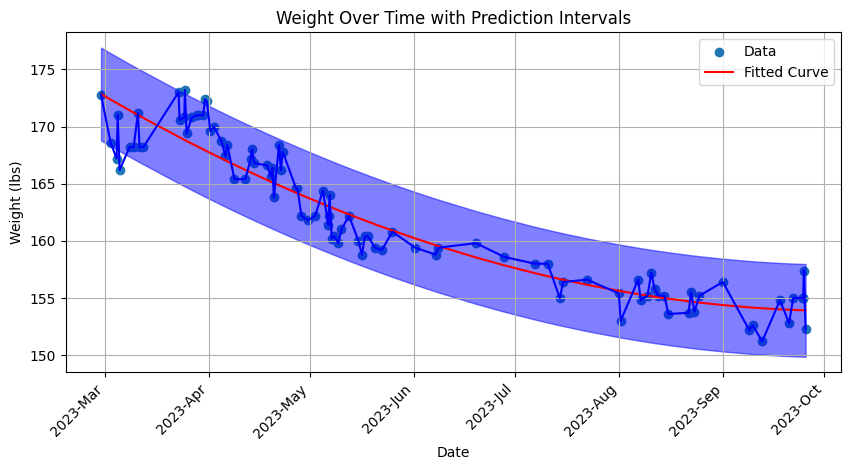

In [254]:


# Plotting



# Assuming 'predictions' is your array of predicted values and 'y_test' is the actual values
#plt.scatter(y_test, predictions, color='blue')
#plt.xlabel('Actual Values')
#plt.ylabel('Predicted Values')
#plt.title('Actual vs. Predicted')
#plt.show()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))
# Set locator for x-axis
#ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
# Set locator for y-axis
#ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
#ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
# Text in the x-axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

#print(get_coord_pairs_from_user("user0"))
#plt.ylim(min(get_coord_pairs_from_user("user0", "body_weight")[2])-5, max(get_coord_pairs_from_user("user0", "body_weight")[2])+5)
#plt.yticks([25,50,75,100,125,150,175,200,225,250])


    

#plt.scatter(x, y, label='Data')
plt.plot(x, y_fit, color='red', label='Fitted Curve')
plt.xlabel('Date')
plt.gcf().autofmt_xdate()
plt.ylabel('Weight (lbs)')
plt.title('Weight Over Time with Prediction Intervals')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.plot(x, y, 'b')

plt.fill_between(x, lower, upper, color='blue', alpha=0.5, label='Confidence Interval')

plt.show()

#alex
#x = get_coord_pairs_from_user("user1", "body_weight")[1]
#y = get_coord_pairs_from_user("user1", "body_weight")[2]
#plt.plot(x, y, 'go')

In [255]:
sheet_id = '1CxCLvg2CGSHYNWskSa8JlBOPmF4th4XPEQQfy6AouYw'
xls = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")

tab1 = pd.read_excel(xls, 'data', header = 1)

tab1

,2023-02-26 20:10:24.513000,sdimov77@gmail.com,Unnamed: 2,Bench,straight,barbell,1,155,8,7,Unnamed: 10,Unnamed: 11,Unnamed: 12,155.1,6,1240,9670,44983
0,2023-02-26 20:12:48.526,sdimov77@gmail.com,NaN,Bench,straight,barbell,2.0,155,8.0,8.0,NaN,NaN,NaN,155,4.0,1240.0,9670.0,44983
1,2023-02-26 20:15:59.527,sdimov77@gmail.com,NaN,Bench,straight,barbell,3.0,155,8.0,9.0,NaN,NaN,NaN,155,6.0,1240.0,9670.0,44983
2,2023-02-26 20:19:36.136,sdimov77@gmail.com,NaN,Bench,straight,barbell,4.0,155,8.0,8.0,NaN,NaN,NaN,155,51.0,1240.0,9670.0,44983
3,2023-02-26 20:22:57.518,sdimov77@gmail.com,NaN,tricep pull,single arm,cable,1.0,25,3.0,8.0,NaN,NaN,NaN,NaN,NaN,75.0,9670.0,44983
4,2023-02-26 20:24:43.467,sdimov77@gmail.com,NaN,tricep pull,single arm,cable,2.0,20,6.0,7.0,NaN,NaN,NaN,NaN,NaN,120.0,9670.0,44983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
745,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
746,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
747,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,#VALUE!
